In [99]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import cv2
from tqdm import tqdm
from scipy.interpolate import interp1d

In [ ]:
# c.f. https://www.gitmemory.com/issue/google/next-prediction/6/507110532

In [9]:
obsmat = np.loadtxt('/data/trajnet/ETH/ewap_dataset/seq_hotel/obsmat.txt')
imglist = sorted(glob('/data/CROWD_DATASETS/ETH_UCY/input_frames/seq_hotel/*.jpg'))

In [10]:
# apply homography

H = np.loadtxt('/data/trajnet/ETH/ewap_dataset/seq_hotel/H.txt')
_, H_ = cv2.invert(np.array(H))
meter_pts = np.vstack((obsmat[:, 2], obsmat[:, 4])).T[np.newaxis]
pixel_pts = cv2.perspectiveTransform(meter_pts, H_).squeeze()
data = np.hstack((obsmat[:, :2], pixel_pts))

In [175]:
# linear inter/exterop

def my_interp(x, y, t_min, t_max):
    val = interp1d(x, y, bounds_error=False, fill_value='extrapolate')(np.arange(t_min, t_max)).astype('int')
    return val


track_id = data[:, 1]
unique_id = np.unique(track_id)
data_interp = []

ext_time = 25

for u in unique_id:
    data_ = data[track_id == u, :]
    if(len(data_) > 1):
        t_min = data_[:, 0].min()
        t_max = data_[:, 0].max()
        data_interp.append(np.vstack([my_interp(data_[:, 0], data_[:, i], t_min - ext_time, t_max + ext_time) for i in range(4)]).T)
data_interp = np.concatenate(data_interp)
data_interp = data_interp[(data_interp[:, 2] >= 0) & (data_interp[:, 2] < 576) & (data_interp[:, 3] >= 0) & (data_interp[:, 3] < 720) & (data_interp[:, 0] >= 0) & (data_interp[:, 0] < data[:, 0].max())]

print(len(data_interp))
np.savetxt('hotel_gt_%02d.txt' % ext_time, data_interp, fmt='%d')

77475


In [176]:
!pwd

/workspace/programs/C-3-Framework


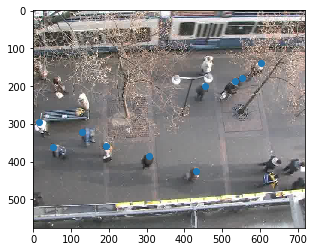

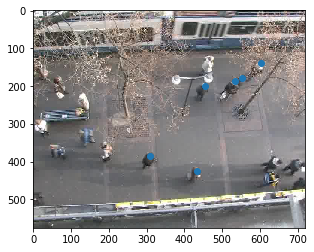

In [148]:
plt.figure()
t = 10
plt.imshow(imread(imglist[t - 1]))
plt.scatter(data_interp[data_interp[:, 0] == t, 3], data_interp[data_interp[:, 0] == t, 2])

plt.figure()
t = 11
plt.imshow(imread(imglist[t - 1]))
plt.scatter(data_interp[data_interp[:, 0] == t, 3], data_interp[data_interp[:, 0] == t, 2])

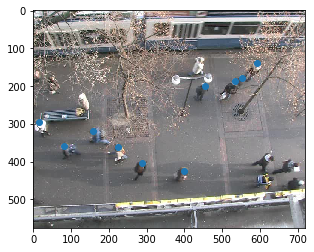

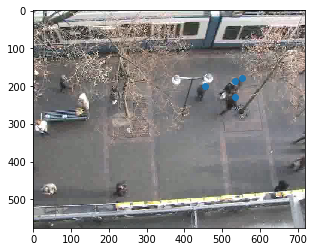

In [167]:
plt.figure()
t = 1
plt.imshow(imread(imglist[t - 1]))
plt.scatter(data_interp[data_interp[:, 0] == t, 3], data_interp[data_interp[:, 0] == t, 2])

plt.figure()
t = 101
plt.imshow(imread(imglist[t - 1]))
plt.scatter(data_interp[data_interp[:, 0] == t, 3], data_interp[data_interp[:, 0] == t, 2])

In [20]:
!cat '/data/trajnet/ETH/ewap_dataset/README.txt'

DATASET: ETH Walking Pedestrians (EWAP)

Each directory contains a video together with the annotation and the obstacle map used. Please read the following for some details about the provided files. In each sequence directory there is a info.txt file with some sequence specific information.


OBSMAT
The actual annotation is stored in the obsmat.txt file. Each line has this format

[frame_number pedestrian_ID pos_x pos_z pos_y v_x v_z v_y ]

however pos_z and v_z (direction perpendicular to the ground) are not used. The positions and velocities are in meters and are obtained with the homography matrix stored in H.txt .
Please note that we tried to avoid annotating those subjects that were at the border of the scene, as their behavior might have been influenced by the presence of other pedestrians/obstacles not in the field of view of the camera. We tried to be as consistent as possible in this regard. 


GROUPS
We tried to keep note of the people that seemed to walk in groups. These are 